In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import time
from scipy.stats import multivariate_normal

from RCT_experiment import *
from Bayes_linear_regression import *
from plotting_functions import *
from MCMC_Bayesian_update import *
from utils import *


/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(44)
show_plots = True

n_host_and_mirror = 1000
X0 = np.random.randint(0, 2, size=n_host_and_mirror)
X1 = np.random.normal(size=n_host_and_mirror)
x_distributions = {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 3*X_1 + eps)
X_rct, T_rct = generate_rct(n_host_and_mirror, x_distributions)

data_host, data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2)
design_data_host = generate_design_matrix(data_host, power_x=1, power_x_t=1)
design_data_mirror = generate_design_matrix(data_mirror, power_x=1, power_x_t=1)

n_pre_cand2 = 500
pre_X_cand2, pre_T_cand2 = generate_rct(n_pre_cand2, x_distributions)
data_cand2 = generate_host2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2=100)
design_data_cand2 = generate_design_matrix(data_cand2, power_x=1, power_x_t=1)

outcome_function = lambda X, T, eps: 1 + 0 * X[:,0] + 1 * X[:,1] + 1 * T - 0* X[:,1]*T + eps 
std_true_y = 0.0 # Standard deviation for the true Y
design_data_host = add_outcome(design_data_host, outcome_function, std_true_y)
design_data_mirror = add_outcome(design_data_mirror, outcome_function, std_true_y)
design_data_cand2 = add_outcome(design_data_cand2, outcome_function, std_true_y)

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

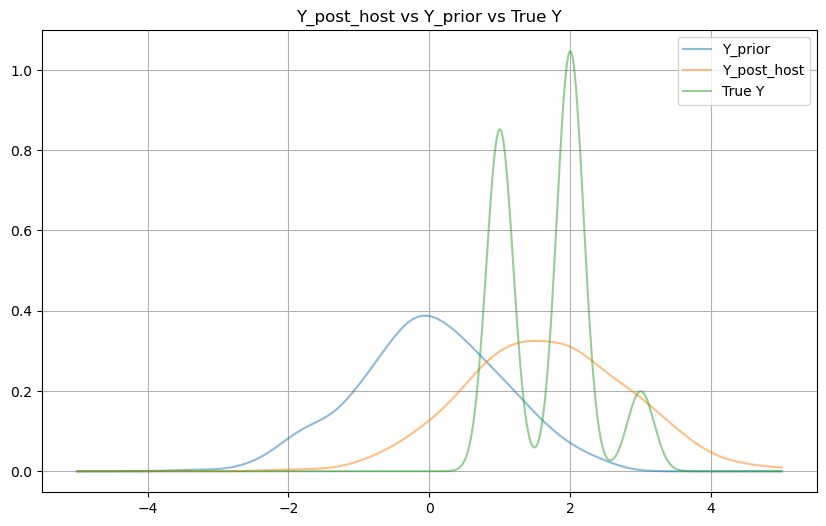

In [3]:
# Initialize prior parameters
# post_mean = np.array([-10, 0.5, 2, -10, 0, -4])
# a = beta_post_host_vec
post_mean = np.array([0, 0, 0, 0, 0, 0])
beta_0, sigma_0_sq = post_mean, 3
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


In [4]:
np.var(Y_prior)

1.0628165328589463

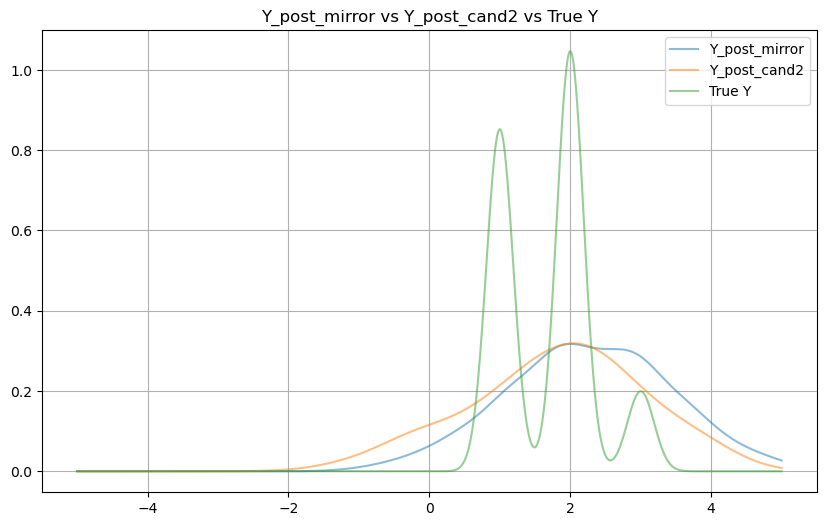

In [5]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

## With candidate = mirror dataset
bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [6]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 200
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 500
max_tree_depth = 7
sigma_rand_error = 1

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = 3, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 3700/3700 [00:24, 151.54it/s, step size=4.12e-01, acc. prob=0.911]

Inference ran for 0.41 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      1.00      0.08      1.00      0.88      1.13   1996.05      1.00
    beta_1      0.99      0.19      0.99      0.67      1.29   1543.50      1.00
    beta_2      0.00      0.07      0.00     -0.11      0.11   1859.96      1.00
    beta_3      0.99      0.11      1.00      0.82      1.17   2021.54      1.00
    beta_4      0.02      0.26      0.02     -0.41      0.44   1574.75      1.00
    beta_5     -0.00      0.10     -0.00     -0.15      0.16   1840.21      1.00

Number of divergences: 0


### We should have that the mean of beta_post_host is beta_post_host_vec here

In [7]:
X_host.shape

(421, 6)

In [8]:
[1, 0, 1, 1, 0, 0]

[1, 0, 1, 1, 0, 0]

In [9]:
beta_post_host_vec

array([ 1.00000000e+00,  1.00000000e+00, -4.32162549e-17,  1.00007010e+00,
       -2.43039434e-02, -3.92248521e-03])

In [10]:
beta_post_host.cov()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,0.005883,-0.005805,0.000539,-0.005955,0.005936,-0.000542
beta_1,-0.005805,0.036131,-0.000401,0.005289,-0.035502,0.001037
beta_2,0.000539,-0.000401,0.004577,-0.000461,0.000107,-0.004604
beta_3,-0.005955,0.005289,-0.000461,0.011587,-0.011414,0.000467
beta_4,0.005936,-0.035502,0.000107,-0.011414,0.067327,-0.001487
beta_5,-0.000542,0.001037,-0.004604,0.000467,-0.001487,0.009287


In [11]:
pd.DataFrame(cov_matrix_post_host)

,0,1,2,3,4,5
0,0.005870,-0.005871,0.000312,-0.005870,0.005871,-0.000312
1,-0.005871,0.035284,-0.000332,0.005871,-0.035284,0.000332
2,0.000312,-0.000332,0.004452,-0.000312,0.000332,-0.004452
3,-0.005870,0.005871,-0.000312,0.011553,-0.011543,0.000230
4,0.005871,-0.035284,0.000332,-0.011543,0.065831,-0.000903
5,-0.000312,0.000332,-0.004452,0.000230,-0.000903,0.009027


### 3. Calculating EIG

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [12]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [13]:
sigma_rand_error

1

In [14]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

3.469229115991652

Now to calculate for the causal

In [15]:
from functools import partial
from MCMC_Bayesian_update import retun_causal_samp_func_linear


In [16]:
sample_func = retun_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [17]:
# pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

In [18]:
# compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

Now, trying to calculate in closed form

In [22]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

3.1724193060681696

In [23]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

0.9483106774121013

For the cand2 dataset

In [28]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [29]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

0.6159920032613329

Now, trying to calculate in closed form

In [30]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

0.2877203927716551

In [27]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

0.018602247389986948